In [129]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import networkx as nx

import torch.nn.functional as F

# import torch_geometric.data into environment
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric import nn
import torch_geometric.transforms as T
from torch_geometric.nn import GATv2Conv

from torch_geometric.nn.pool import global_mean_pool

from torch.utils.data import random_split

from torch_geometric.loader import DataLoader

from utils import draw_smiles, my_draw_networkx_edge_labels

from pysmiles import read_smiles #Unused

from tqdm import tqdm

from time import time

from scipy.stats import linregress

#Random graphs
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# check if GPU is available and detectable. cpu is ok for this homework.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [130]:
class OneHotTransform:
    def __init__(self, untransformed):
        self.full_x = untransformed.x
        self.full_x_slices = untransformed.slices['x']
        self.full_edges = untransformed.edge_attr
        self.full_edge_slices = untransformed.slices["edge_index"]
        
        self.index = 0
        self.edge_index = 0

    def __call__(self, data: Data):
        tensors = []
        for i in range(self.full_x.shape[1]):
            unique, unique_indices = torch.unique(self.full_x[:, i], return_inverse = True)

            if len(unique) > 2:
                tensors.append(F.one_hot(unique_indices, len(unique)))
            elif len(unique) == 2:
                tensors.append(self.full_x[:, i].reshape(-1, 1))

        new_x = torch.cat(tensors, dim = 1)

        start = self.full_x_slices[self.index]
        end = self.full_x_slices[self.index + 1]
        data.x = new_x[start:end]


        tensors = []
        for i in range(self.full_edges.shape[1]):
            unique, unique_indices = torch.unique(self.full_edges[:, i], return_inverse = True)

            if len(unique) > 2:
                tensors.append(F.one_hot(unique_indices, len(unique)))
            elif len(unique) == 2:
                tensors.append(self.full_edges[:, i].reshape(-1, 1))

        new_edges = torch.cat(tensors, dim = 1)

        start = self.full_edge_slices[self.index]
        end = self.full_edge_slices[self.index + 1]
        data.edge_attr = new_edges[start:end]

        self.index += 1

        return data

In [131]:
dataset_name = "FreeSolv"
dataset_untransformed = MoleculeNet('./data', dataset_name)

In [132]:
dataset_untransformed.slices

{'x': tensor([    0,    32,    47,  ..., 14967, 14972, 14991]),
 'edge_index': tensor([    0,    68,   100,  ..., 30810, 30818, 30856]),
 'edge_attr': tensor([    0,    68,   100,  ..., 30810, 30818, 30856]),
 'smiles': tensor([   0,    1,    2,  ..., 1126, 1127, 1128]),
 'y': tensor([   0,    1,    2,  ..., 1126, 1127, 1128])}

In [133]:
tensors = []
for i in range(dataset_untransformed.x.shape[1]):
    print(f"Unique values, column {i}")
    unique, unique_indices = torch.unique(dataset_untransformed.x[:, i], return_inverse = True)
    print(unique)
    print(len(unique))

    if len(unique) > 2:
        tensors.append(F.one_hot(unique_indices, len(unique)))
    elif len(unique) == 2:
        tensors.append(dataset_untransformed.x[:, i].reshape(-1, 1))

new_x = torch.cat(tensors, dim = 1)
print(new_x.shape)

print("Atomic number (one-hot), chirality (one-hot), degree (one-hot), valence (one-hot), number of bonded hydrogens (one-hot), number of radicals (omitted), hybridization (one-hot), aromatic, in ring")

edge_tensors = []
for i in range(dataset_untransformed.edge_attr.shape[1]):
    print(f"Unique values, column {i}")
    unique, unique_indices = torch.unique(dataset_untransformed.edge_attr[:, i], return_inverse = True)
    print(unique)
    print(len(unique))

    if len(unique) > 2:
        edge_tensors.append(F.one_hot(unique_indices, len(unique)))
    elif len(unique) == 2:
        edge_tensors.append(dataset_untransformed.edge_attr[:, i].reshape(-1, 1))

new_x = torch.cat(edge_tensors, dim = 1)
print(new_x.shape)

print("Aromaticity, bond stereochemistry, conjugation")

Unique values, column 0
tensor([ 6,  7,  8,  9, 15, 16, 17, 35, 53])
9
Unique values, column 1
tensor([0])
1
Unique values, column 2
tensor([1, 2, 3, 4])
4
Unique values, column 3
tensor([4, 5, 6])
3
Unique values, column 4
tensor([0, 1, 2, 3, 4])
5
Unique values, column 5
tensor([0])
1
Unique values, column 6
tensor([2, 3, 4])
3
Unique values, column 7
tensor([0, 1])
2
Unique values, column 8
tensor([0, 1])
2
torch.Size([14991, 26])
Atomic number (one-hot), chirality (one-hot), degree (one-hot), valence (one-hot), number of bonded hydrogens (one-hot), number of radicals (omitted), hybridization (one-hot), aromatic, in ring
Unique values, column 0
tensor([ 1,  2,  3, 12])
4
Unique values, column 1
tensor([0, 2, 3])
3
Unique values, column 2
tensor([0, 1])
2
torch.Size([30856, 8])
Aromaticity, bond stereochemistry, conjugation


In [6]:
dataset = MoleculeNet('./data', dataset_name, pre_transform = OneHotTransform(dataset_untransformed), force_reload = True)

Processing...
Done!


In [7]:

dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train dataset: {len(train_dataset)} graphs")
print(f"Val dataset: {len(val_dataset)} graphs")
print(f"Test dataset: {len(test_dataset)} graphs")

Train dataset: 676 graphs
Val dataset: 225 graphs
Test dataset: 227 graphs


In [8]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim, heads=8, dropout=0.2):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout, edge_dim = edge_dim)
        self.relu = torch.nn.ReLU()
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout, edge_dim = edge_dim)
        self.conv3 = GATv2Conv(hidden_channels * heads, in_channels, heads=1, dropout=dropout, edge_dim = edge_dim)

        self.conv_single = GATv2Conv(in_channels, in_channels, heads = 1, dropout = dropout, edge_dim = edge_dim)
        self.linear_1 = torch.nn.Linear(in_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.edge_attr
        attn_weights = [None] * 3
        x, attn_weights[0] = self.conv1(x, edge_index, edge_attr = edge_attr, return_attention_weights= True)
        x = self.relu(x)
        x, attn_weights[1] = self.conv2(x, edge_index, edge_attr = edge_attr,  return_attention_weights= True)
        x = self.relu(x)
        x, attn_weights[2] = self.conv3(x, edge_index, edge_attr = edge_attr,  return_attention_weights= True)
        
        #x, attn_weights[0] = self.conv_single(x, edge_index, edge_attr = edge_attr, return_attention_weights= True)

        x = self.relu(x)
        x = self.linear_1(x)
        x = nn.pool.global_mean_pool(x, data.batch)
        return x, attn_weights

In [10]:
def train(model, loader, optimizer, loss_fn, epoch_no):
    epoch_loss = 0
    model.train()

    epoch_iter = tqdm(loader, desc = "Train", ncols = 130)
    for batch in epoch_iter:
        optimizer.zero_grad()
        y_pred, _ = model(batch)

        loss = loss_fn(y_pred, batch.y)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iter.set_description(f"epoch: {epoch_no}, train_loss: {loss:.4f}")


    return epoch_loss/len(loader)


@torch.no_grad()
def test(model, loader):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, ncols = 130, desc = "Eval"):
            y_pred, _ = model(batch)
            loss = torch.nn.MSELoss()(y_pred, batch.y)

            epoch_loss += loss.item()
    
    return np.sqrt(epoch_loss/len(loader))

In [11]:
epoch_list = [5, 10, 20, 40, 80]
batch_sizes = [1, 10, 20, 40]
loss_fn_strings = ["MSE", "L1"]
lrs = [0.003, 0.001, 0.0003, 0.0001]

hyperparameters_df = pd.DataFrame(columns = ["Epochs", "Batch size", "Loss function", "Learning rate", "Validation RMSE"])

In [12]:
for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
    val_loader = DataLoader(val_dataset, shuffle = True, batch_size = batch_size)


    for loss_fn_string in loss_fn_strings:
        if loss_fn_string == "MSE":
            loss_fn = torch.nn.MSELoss()
        elif loss_fn_string == "L1":
            loss_fn = torch.nn.L1Loss()
        for lr in lrs:

            in_dimensions = dataset.x.shape[1]
            print(in_dimensions)
            model = GAT(in_dimensions, in_dimensions * 2, edge_dimensions)
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)


            all_epochs = np.arange(max(epoch_list))
            all_train_loss = []
            all_val_loss = []

            for epoch in all_epochs:

                start_time = time()  # record the start time

                train_loss = train(model, train_loader, optimizer, loss_fn, epoch)
                all_train_loss.append(train_loss)

                end_time = time()

                epoch_time = end_time - start_time

                #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_time}s')
                #print(f'\tTrain Loss: {train_loss:.3f}')

                val_rmse = test(model, val_loader)
                all_val_loss.append(val_rmse)
                #print(f'Val RMSE: {val_rmse:.3f}')


                if epoch +1 in epoch_list:
                    hyperparameters_df.loc[len(hyperparameters_df)] = [epoch, batch_size, loss_fn_string, lr, val_rmse]




26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                               | 0/225 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                | 0/12 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

26


Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval:   0%|                                                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_w

In [23]:
display(hyperparameters_df)
hyperparameters_df.to_csv(f"{dataset_name}_hyperparameters.csv", index = False)

hyperparameters_df = pd.read_csv(f"{dataset_name}_hyperparameters.csv")
hyperparameters_df

Epochs  Batch size Loss function  Learning rate  Validation RMSE
0         4           1           MSE         0.0030         1.127084
1         9           1           MSE         0.0030         1.330129
2        19           1           MSE         0.0030         0.762826
3        39           1           MSE         0.0030         0.642671
4        79           1           MSE         0.0030         0.613535
..      ...         ...           ...            ...              ...
155       4          40            L1         0.0001         2.280804
156       9          40            L1         0.0001         2.152025
157      19          40            L1         0.0001         2.020515
158      39          40            L1         0.0001         1.614606
159      79          40            L1         0.0001         1.251936

[160 rows x 5 columns]

Epochs  Batch size Loss function  Learning rate  Validation RMSE
0         4           1           MSE         0.0030         1.127084
1         9           1           MSE         0.0030         1.330129
2        19           1           MSE         0.0030         0.762826
3        39           1           MSE         0.0030         0.642671
4        79           1           MSE         0.0030         0.613535
..      ...         ...           ...            ...              ...
155       4          40            L1         0.0001         2.280804
156       9          40            L1         0.0001         2.152025
157      19          40            L1         0.0001         2.020515
158      39          40            L1         0.0001         1.614606
159      79          40            L1         0.0001         1.251936

[160 rows x 5 columns]

<Axes: title={'center': 'ESOL, L1 loss function'}, xlabel='Epochs', ylabel='Validation RMSE'>

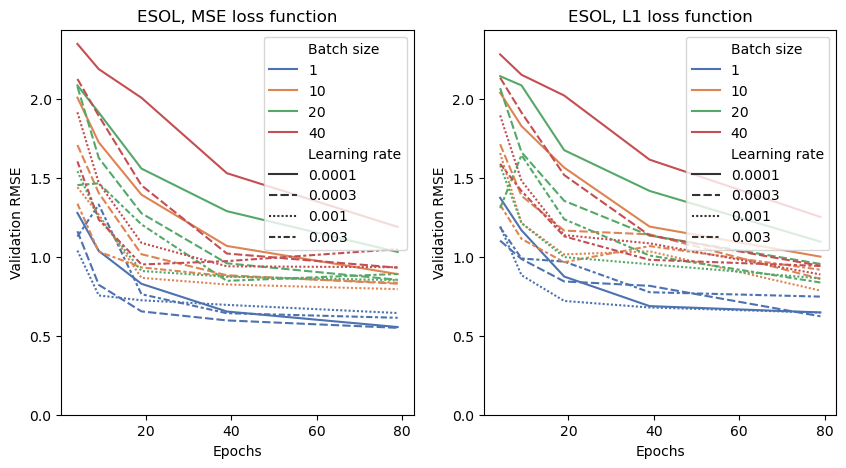

In [ ]:
plt.figure(figsize = (10, 5))
ax_1 = plt.subplot(121)
plt.title(f"{dataset_name}, MSE loss function")
sns.lineplot(hyperparameters_df.loc[hyperparameters_df["Loss function"] == "MSE"], x = "Epochs", y = "Validation RMSE", hue = "Batch size", style = "Learning rate", palette = "deep")
ax_1.set_ylim(ymin = 0)

ax_2 = plt.subplot(122)
ax_2.sharey(ax_1)  # Link the x-axes
plt.title(f"{dataset_name}, L1 loss function")
sns.lineplot(hyperparameters_df.loc[hyperparameters_df["Loss function"] == "L1"], x = "Epochs", y = "Validation RMSE", hue = "Batch size", style = "Learning rate", palette = "deep")

plt.show()




# Best Model

In [118]:
#Model of choice: MSE loss, batch size 10, learning rate 0.001. Run model 3 times

batch_size = 10
loss_fn = torch.nn.MSELoss()
lr = 0.001
num_epochs = 40

train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
val_loader = DataLoader(val_dataset, shuffle = True, batch_size = batch_size)

in_dimensions = dataset.x.shape[1]
print(in_dimensions)
model = GAT(in_dimensions, in_dimensions * 2, edge_dimensions)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


all_epochs = np.arange(num_epochs)
all_train_loss = []
all_val_loss = []

for epoch in all_epochs:

    start_time = time()  # record the start time

    train_loss = train(model, train_loader, optimizer, loss_fn, epoch)
    all_train_loss.append(train_loss)

    end_time = time()

    epoch_time = end_time - start_time

    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_time}s')
    #print(f'\tTrain Loss: {train_loss:.3f}')

    val_rmse = test(model, val_loader)
    all_val_loss.append(val_rmse)
    #print(f'Val RMSE: {val_rmse:.3f}')


26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval: 100%|██████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 147.52it/s]


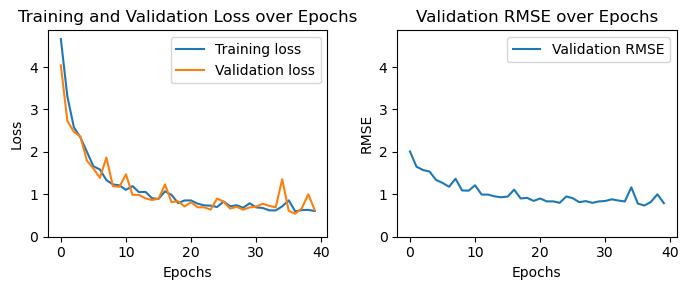

In [136]:
plt.figure(figsize=(7, 3))
ax_1 = plt.subplot(121)
plt.title("Training and Validation Loss over Epochs")
plt.plot(all_epochs, all_train_loss, label = "Training loss")
plt.plot(all_epochs, np.array(all_val_loss)**2, label = "Validation loss")
ax_1.set_ylim(ymin = 0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

ax_2 = plt.subplot(122)
plt.title("Validation RMSE over Epochs")
plt.plot(all_epochs, all_val_loss, label = "Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()

ax_2.sharey(ax_1)


plt.show()


In [85]:
#Train model 5 times, saving test predictions from each one.
#Model of choice: MSE loss, batch size 10, learning rate 0.001. Run model 3 times

batch_size = 10
loss_fn = torch.nn.MSELoss()
lr = 0.001
num_epochs = 40
num_runs = 5

multirun_results = pd.DataFrame(columns = ["smiles", "y", "y_hat"])


for i in range(num_runs):
    
    train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
    val_loader = DataLoader(val_dataset, shuffle = True, batch_size = batch_size)
    test_loader = DataLoader(test_dataset, shuffle = False, batch_size = 1)


    in_dimensions = dataset.x.shape[1]
    print(in_dimensions)
    model = GAT(in_dimensions, in_dimensions * 2, edge_dimensions)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)


    all_epochs = np.arange(num_epochs)
    all_train_loss = []
    all_val_loss = []

    #Training
    for epoch in all_epochs:

        start_time = time()  # record the start time

        train_loss = train(model, train_loader, optimizer, loss_fn, epoch)
        all_train_loss.append(train_loss)

        end_time = time()

        epoch_time = end_time - start_time

        #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_time}s')
        #print(f'\tTrain Loss: {train_loss:.3f}')

        val_rmse = test(model, val_loader)
        all_val_loss.append(val_rmse)

    #Testing
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for g_num, batch in enumerate(test_loader):
            y_pred, _ = model(batch)
            loss = torch.nn.MSELoss()(y_pred, batch.y)

            epoch_loss += loss.item()  

            multirun_results.loc[len(multirun_results)] = [batch.smiles[0], batch.y.item(), y_pred.item()]

    

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 58.90it/s]
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 87.56it/s]
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval: 100%|██████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 123.57it/s]
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval: 100%|██████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 120.49it/s]
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch

26


Eval:   0%|                                                                                                | 0/23 [00:00<?, ?it/s]C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1565304989.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
Eval: 100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 61.34it/s]
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch.nn.MSELoss()(y_pred, batch.y))
C:\Users\mrwun\AppData\Local\Temp\ipykernel_2016\1117083067.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = np.sqrt(torch

In [108]:
multirun_results.to_csv(f"{dataset_name}_multirun_results.csv", index = False)



multirun_results = pd.read_csv(f"{dataset_name}_multirun_results.csv")
means = multirun_results.groupby("smiles").mean()
stderr = multirun_results.groupby("smiles").std()/np.sqrt(num_runs)

rmse = np.sqrt(np.mean((means['y'] - means['y_hat'])**2))

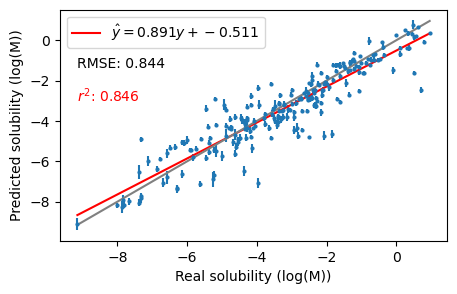

In [141]:
plt.figure(figsize = (5, 3))
plt.errorbar(means["y"], means["y_hat"], yerr = stderr["y_hat"], fmt = 'o', markersize = 2)
if dataset_name == "ESOL":
    plt.xlabel("Real solubility (log(M))")
    plt.ylabel("Predicted solubility (log(M))")
elif dataset_name == "FreeSolv":
    plt.xlabel("Real solvation free energy (kcal/mol)")
    plt.ylabel("Predicted solvation free energy (kcal/mol)")

x_vals = np.linspace(np.min(means["y"]), np.max(means["y"]), 10)

result = linregress(means["y"], means["y_hat"])

plt.plot(x_vals, result.slope * x_vals + result.intercept, c = "red", label = r"$\hat{y}=" + f"{result.slope:.3f}y+{result.intercept:.3f}$")

plt.text(min(means["y"]), (plt.ylim()[1] - plt.ylim()[0]) * 0.75 + plt.ylim()[0], f"RMSE: {rmse:.3f}")
plt.text(min(means["y"]), (plt.ylim()[1] - plt.ylim()[0]) * 0.6 + plt.ylim()[0], f"$r^2$: {result.rvalue**2:.3f}", c = "red")
plt.legend()
plt.plot(x_vals, x_vals, c = 'grey')

plt.show()

In [110]:
def detailed_predictions(model, loader):
    model.eval()
    epoch_loss = 0

    all_y = []
    all_y_pred = []
    all_inputs = []
    all_attn = []
    with torch.no_grad():
        for batch in tqdm(loader, ncols = 130, desc = "Eval"):
            y_pred, attn = model(batch)
            all_inputs.append(batch)
            all_attn.append(attn)
            loss = loss_fn(y_pred, batch.y)

            epoch_loss += loss.item()

            all_y_pred.append(y_pred.reshape([-1]))
            all_y.append(batch.y.reshape([-1]))
        
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred).numpy()

            
    
    return epoch_loss/len(loader), all_inputs, all_y, all_y_pred, all_attn

In [111]:
test_loader = DataLoader(test_dataset, shuffle = True, batch_size = 1)
loss, all_inputs, all_y, all_y_pred, all_attn = detailed_predictions(model, test_loader)

Eval: 100%|████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:01<00:00, 174.61it/s]


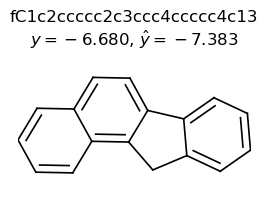

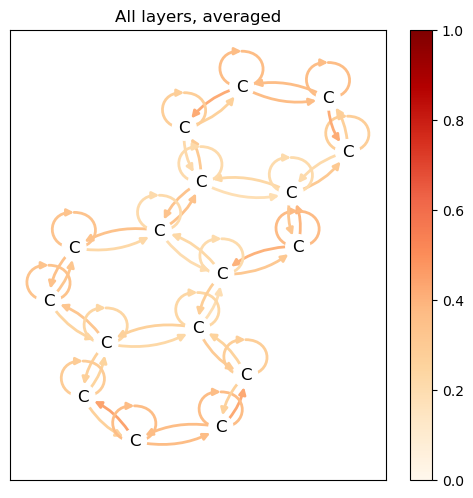

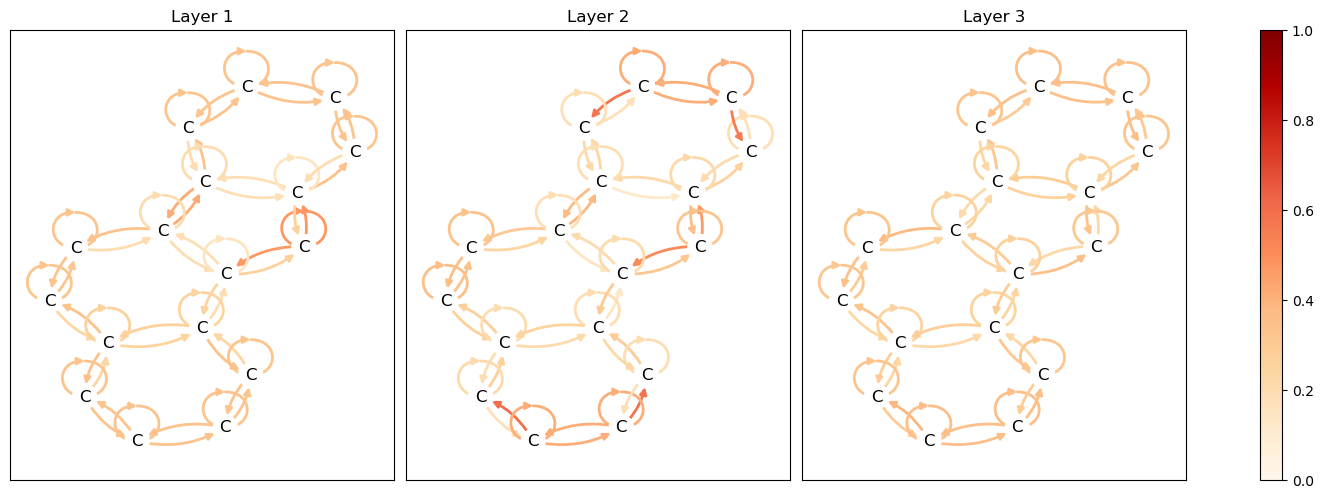

In [115]:
def visualize_attention_map(all_attn, smiles, y, y_hat, rad = 0.2, labels = True, cmap = plt.cm.gist_heat, averaged = False):
    if len(all_attn)  > 1:
        layer_averaged_attn = ((all_attn[0][0], torch.mean((torch.stack([torch.mean(t[1], dim = 1).unsqueeze(0).reshape((-1, 1)) for t in all_attn])), dim = 0)))
        visualize_attention_map([layer_averaged_attn], smiles, y, y_hat, rad, labels, cmap, averaged = True)
    else:
        plt.figure(figsize = (3, 3))
        plt.title(f"f{smiles}\n$y = {y:.3f}$," + r" $\hat{y}" + f" = {y_hat:.3f}$")
        draw_smiles(smiles)
        plt.show()

    plt.figure(figsize = (5 * len(all_attn), 5))
    ax_list = [None] * len(all_attn)
    for i, tup in enumerate(all_attn):
        #plt.suptitle("Averaged Attention Weights")
        ax_list[i] = plt.subplot( 1, len(all_attn), i+1)
        
        if not averaged:
            plt.title(f"Layer {i + 1}")
        else:
            plt.title("All layers, averaged")

        edge_index = tup[0]
        attentions = tup[1]
        #print(tuple)

        averaged_attention = torch.mean(attentions, dim = 1)
        g = read_smiles(smiles).to_directed()

        pos = nx.kamada_kawai_layout(g)
        
        g.add_weighted_edges_from([(edge_index[0, i].item(), edge_index[1, i].item(), averaged_attention[i].item()) for i in range(edge_index.shape[1])])

        
        node_colors = {'C': 'white', 'O': 'lightcoral', 'N': 'cornflowerblue', 'Cl': 'springgreen', 'Br': 'peru'}
        elements = nx.get_node_attributes(g, name = "element")
        edge_weights = nx.get_edge_attributes(g, name = "weight")

        color_map = [node_colors.get(element, 'white') for element in elements.values()]


        nx.draw_networkx_nodes(g, label = elements, pos=pos, node_color = color_map)
        nx.draw_networkx_labels(g, pos, elements)
        #
        #width= (10 * (np.array(list(edge_weights.values()))))
        collection = nx.draw_networkx_edges(g, pos, edge_weights.keys(), edge_color=edge_weights.values(), edge_cmap=cmap, width= 2, arrows = True, connectionstyle=f'arc3, rad = {rad}', edge_vmin = 0, edge_vmax = 1)
        

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))


        
        if labels:
            my_draw_networkx_edge_labels(g, pos, {i: f"{edge_weights[i]:.2f}" for i in edge_weights.keys()}, rad = rad, rotate = False)
        #plt.gca().set_aspect('equal')

        plt.tight_layout()
        if i == len(all_attn) - 1:
            plt.colorbar(sm, ax = ax_list)
        #plt.colorbar()
    plt.show()


graph_num = 1
visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)


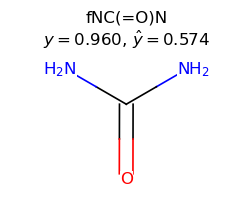

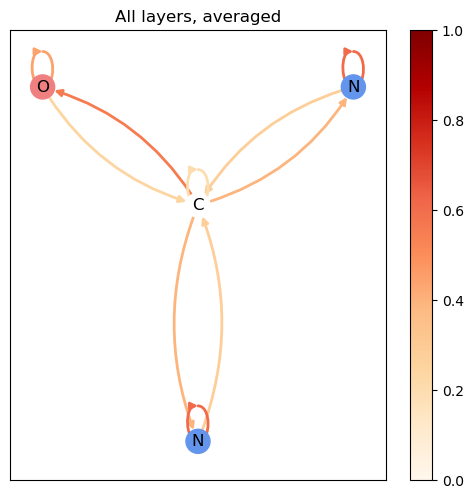

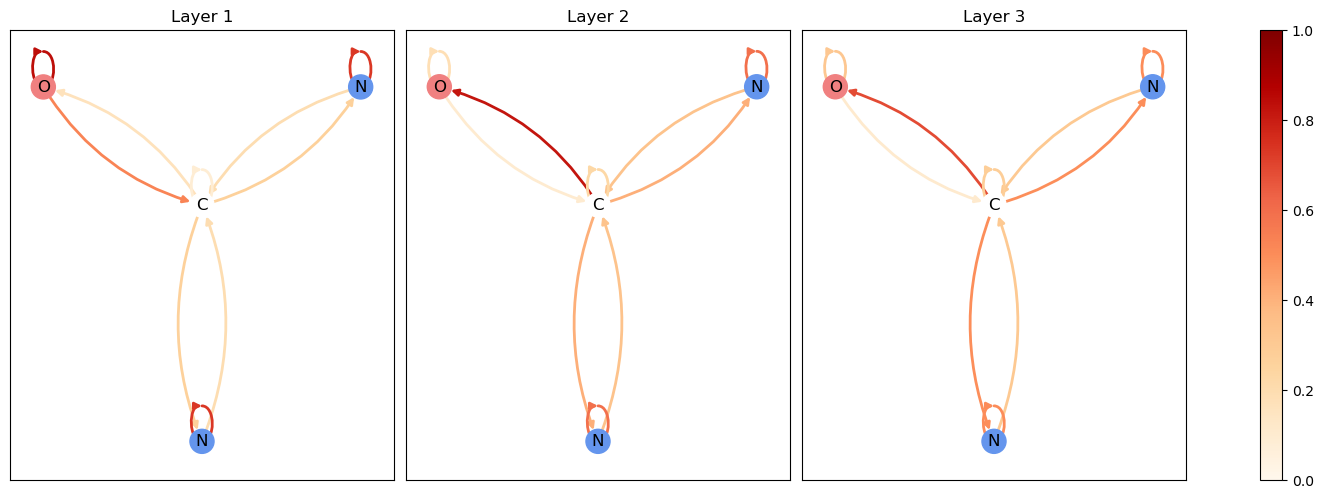

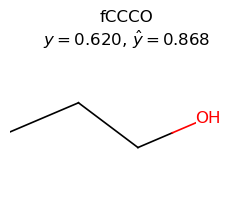

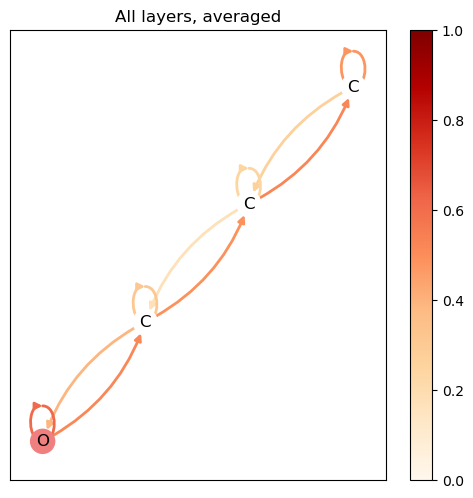

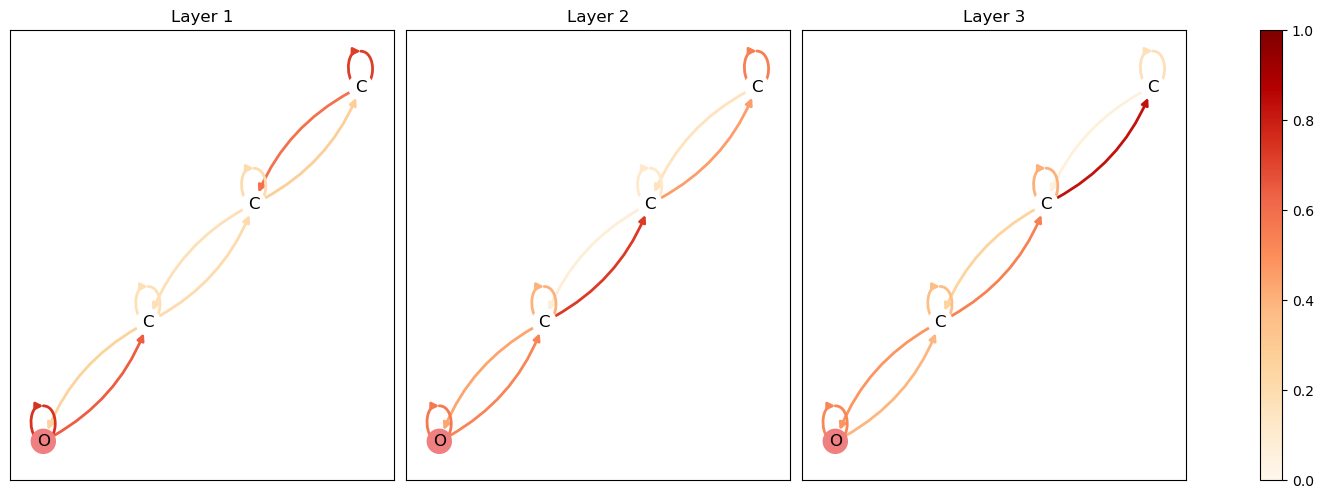

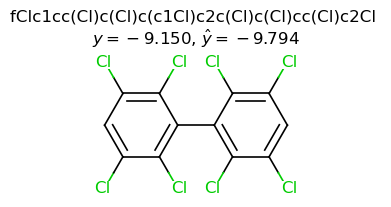

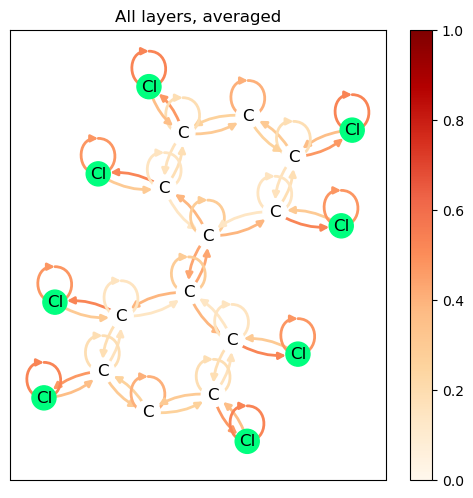

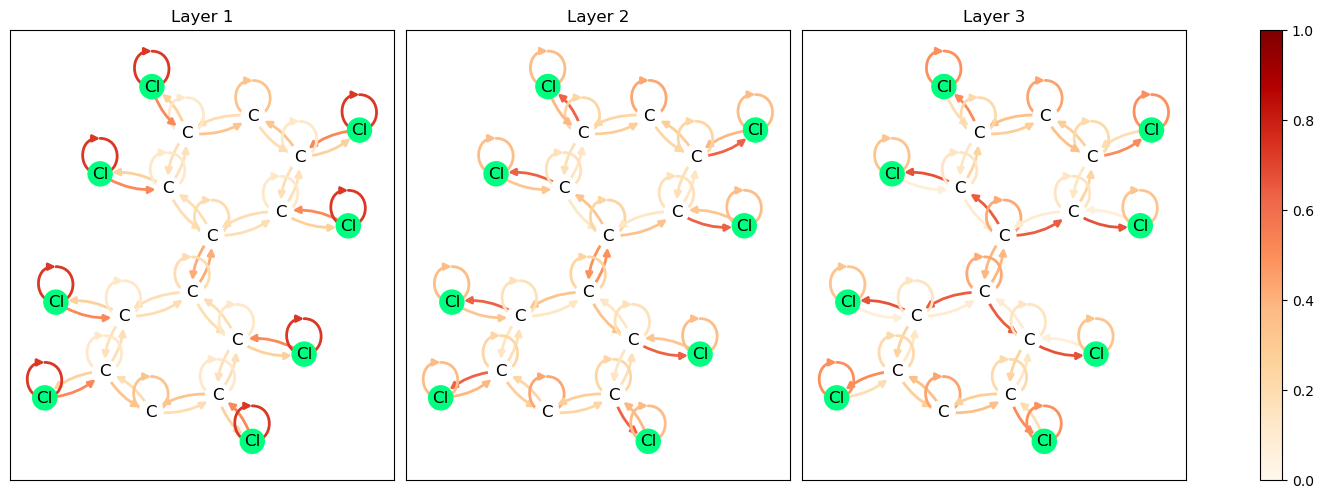

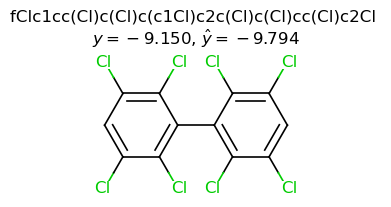

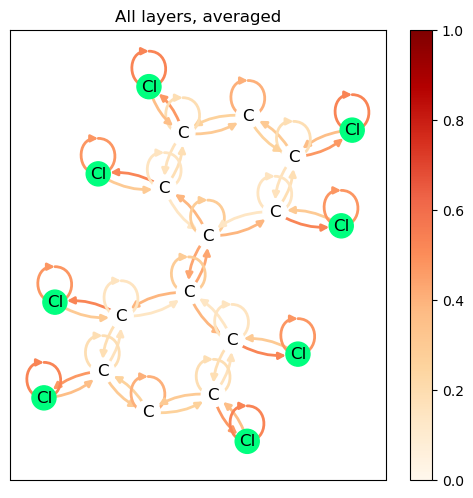

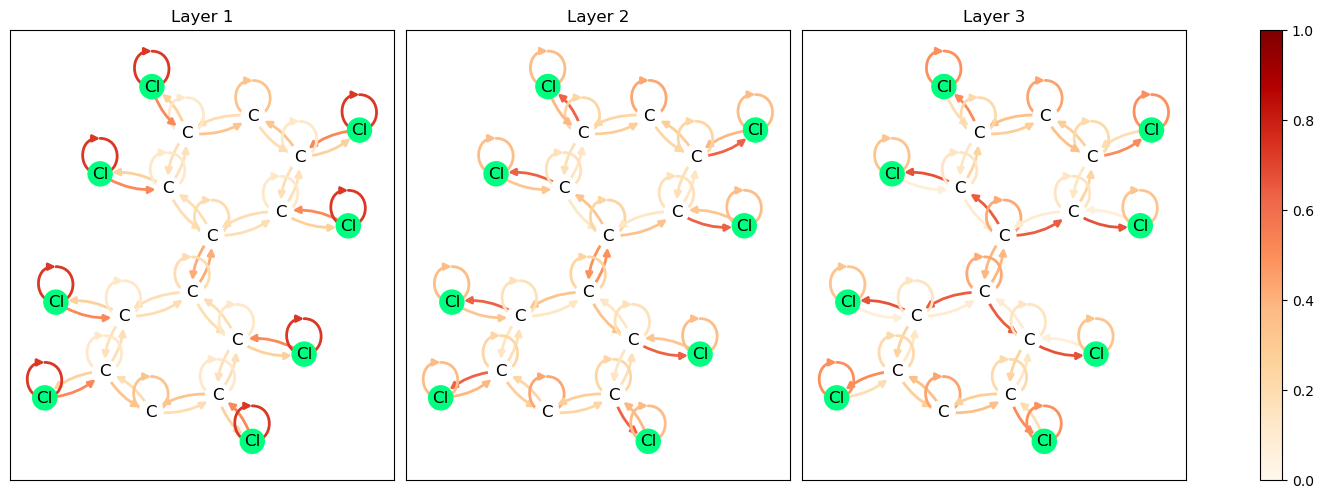

In [116]:
indices_of_interest = [np.argmax(all_y), np.argmax(all_y_pred), np.argmin(all_y), np.argmin(all_y_pred)]

for graph_num in indices_of_interest:
    visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)


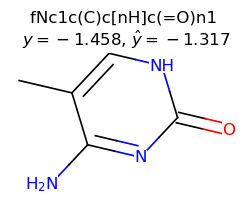

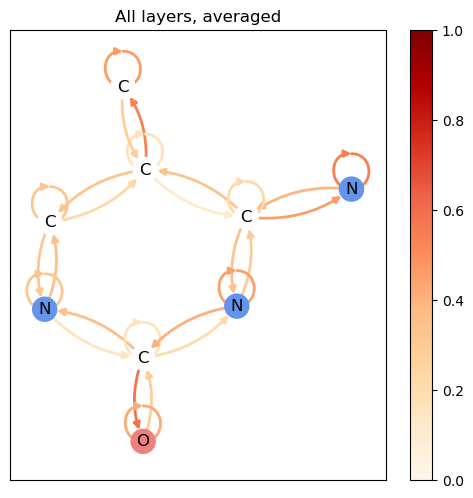

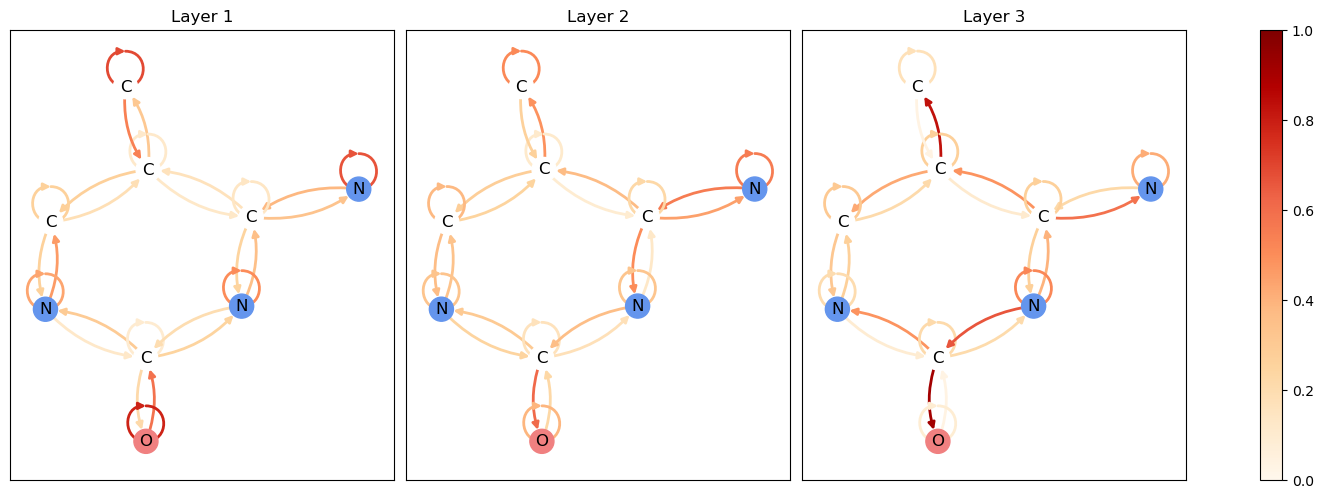

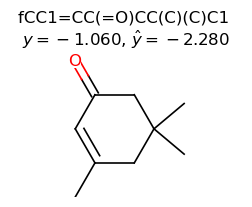

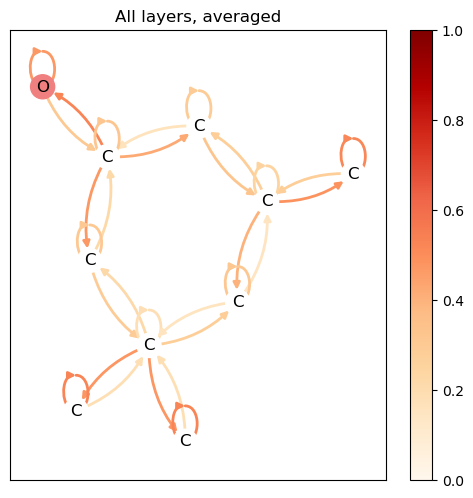

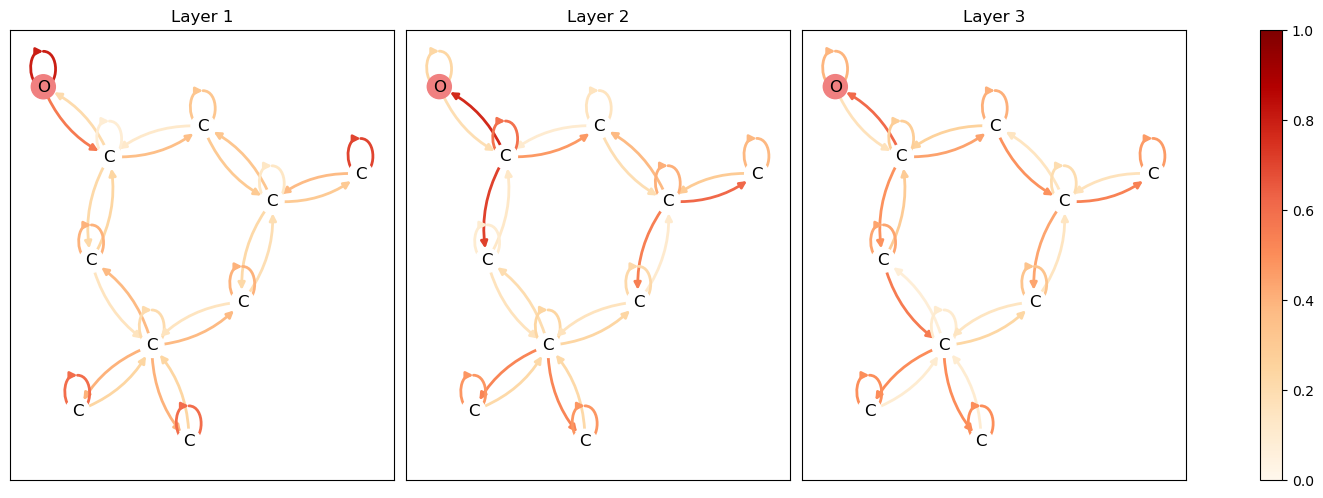

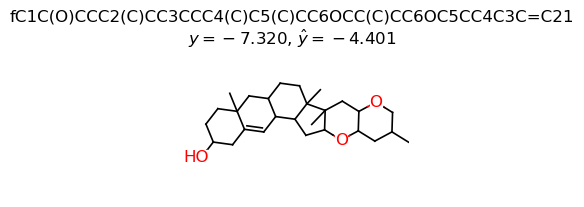

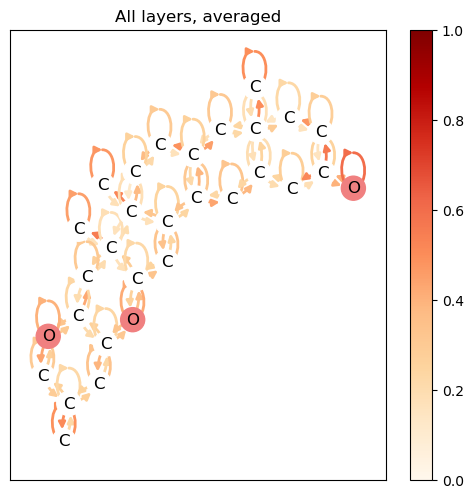

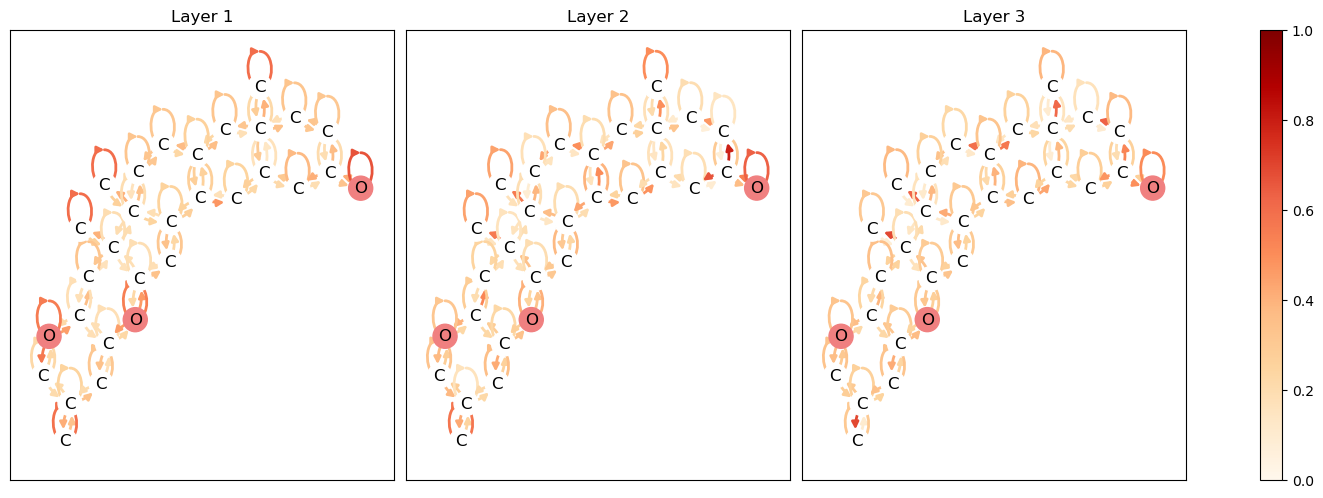

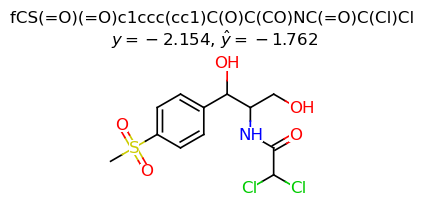

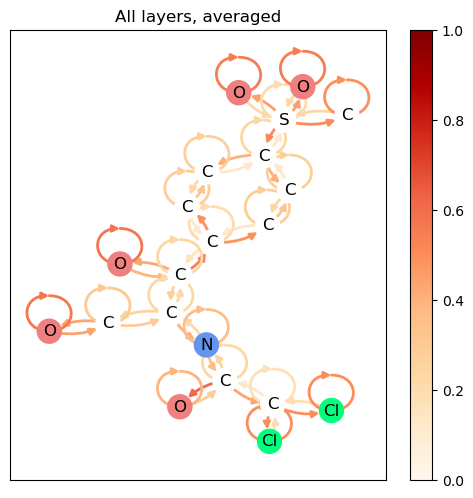

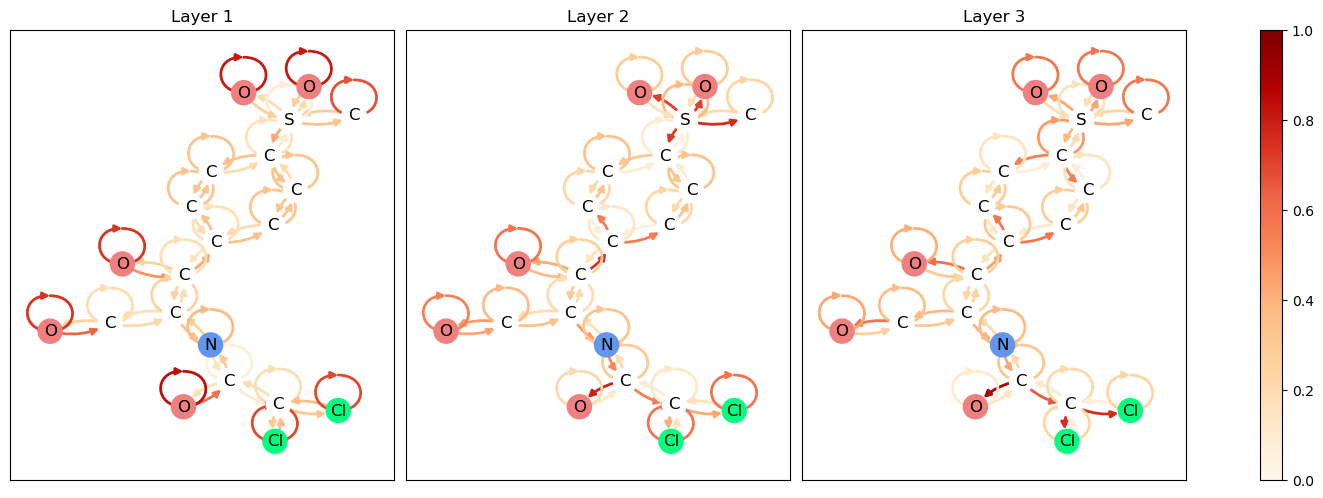

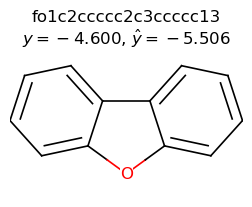

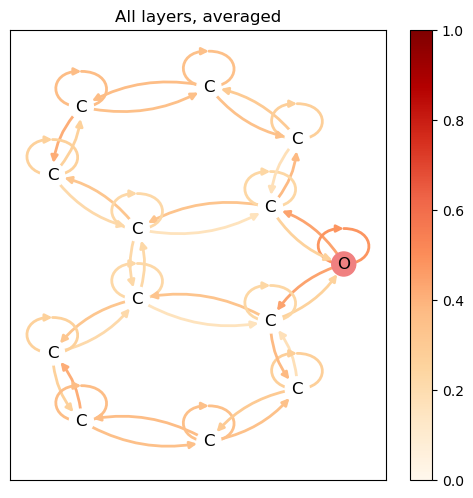

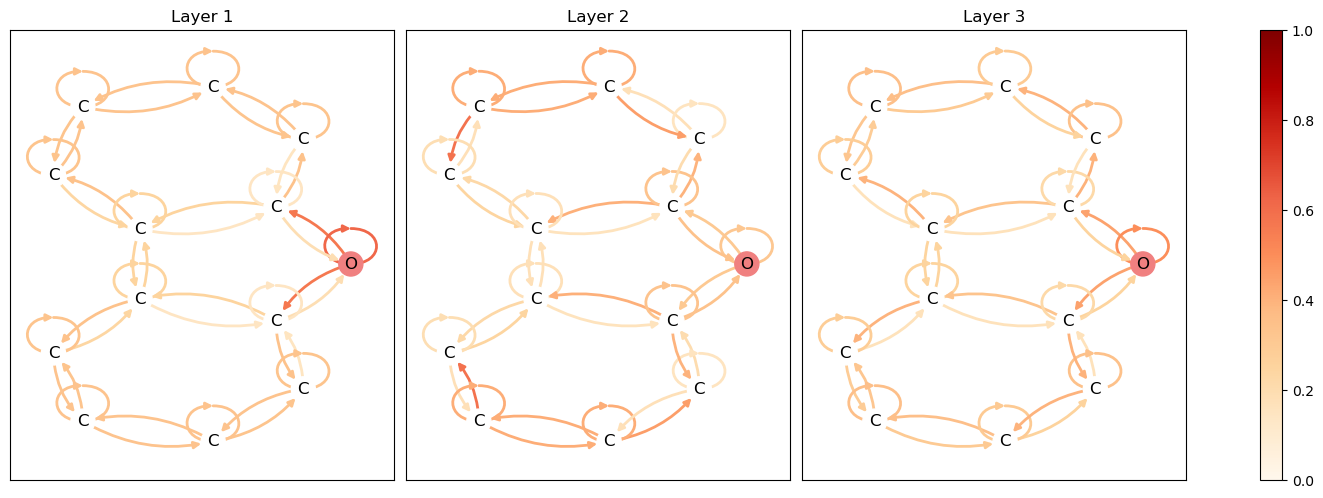

In [117]:
random_indices = random.sample(range(len(all_y)), 5)

for graph_num in random_indices:
    visualize_attention_map(all_attn[graph_num], all_inputs[graph_num].smiles[0], all_y[graph_num], all_y_pred[graph_num], labels = False, cmap = plt.cm.OrRd)